Data source for the analysis in this notebook can be find here: https://www.kaggle.com/c/intercampusai2019/

## Loading Required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Loading Data 

In [2]:
%%time 
train=pd.read_csv('train.csv')
test =pd.read_csv('test.csv')
print('Dataset is loaded !')

Dataset is loaded !
CPU times: user 172 ms, sys: 24.1 ms, total: 197 ms
Wall time: 727 ms


### Getting basic Idea about the data

In [3]:
train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 19 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                         383

In [5]:
train.dtypes.value_counts()

object     11
int64       7
float64     1
dtype: int64

In [6]:
train.duplicated().sum()

0

In [7]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: EmployeeNo                                0
Division                                  0
Qualification                          1679
Gender                                    0
Channel_of_Recruitment                    0
Trainings_Attended                        0
Year_of_birth                             0
Last_performance_score                    0
Year_of_recruitment                       0
Targets_met                               0
Previous_Award                            0
Training_score_average                    0
State_Of_Origin                           0
Foreign_schooled                          0
Marital_Status                            0
Past_Disciplinary_Action                  0
Previous_IntraDepartmental_Movement       0
No_of_previous_employers                  0
Promoted_or_Not                           0
dtype: int64


### Target variable Distribution

Text(0.5,1,'Target variable Distribution')

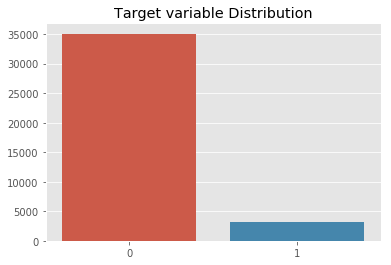

In [8]:
x=train['Promoted_or_Not'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable Distribution')

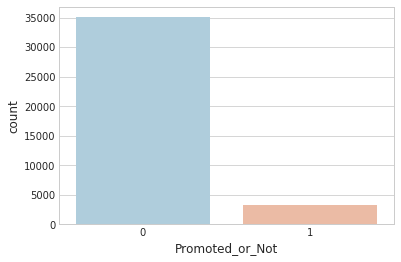

In [9]:
# with seaborn
sns.set_style('whitegrid')
sns.countplot(x = 'Promoted_or_Not',data = train, palette = 'RdBu_r')

In [10]:
Promoted = train.loc[train['Promoted_or_Not'] == 1]
Not_promoted = train.loc[train['Promoted_or_Not'] == 0]
print("We have", len(Promoted), "Promoted data points and", len(Not_promoted), "Not_promoted data points.")

We have 3241 Promoted data points and 35071 Not_promoted data points.


There is clearly a class imbalance problem for this dataset. We will look into methods of solving this issue later in this notebook.

One of the major issues that one can fall into when dealing with unbalanced datasets relates to the metrics used to evaluate the model. Using metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously misleading.

### Dealing with missing values

In [11]:
train['Qualification'].value_counts()

First Degree or HND         25578
MSc, MBA and PhD            10469
Non-University Education      586
Name: Qualification, dtype: int64

In [12]:
train = train.replace(np.nan, 'Not_Specified')
test = test.replace(np.nan, 'Not_Specified')

### Feature Engineering 

In [13]:
train["Grade"] = np.nan
test["Grade"] = np.nan

In [14]:
train.loc[train.Training_score_average < 40, "Grade"] = 'Fail'
train.loc[(train.Training_score_average >= 40) & (train.Training_score_average < 50), "Grade"] = 'Pass'
train.loc[(train.Training_score_average >= 50) & (train.Training_score_average < 60), "Grade"] = 'Credit'
train.loc[(train.Training_score_average >= 60) & (train.Training_score_average < 70), "Grade"] = 'Good'
train.loc[(train.Training_score_average >= 70) & (train.Training_score_average <= 100 ), "Grade"] = 'Excellent'

test.loc[test.Training_score_average < 40, "Grade"] = 'Fail'
test.loc[(test.Training_score_average >= 40) & (test.Training_score_average < 50), "Grade"] = 'Pass'
test.loc[(test.Training_score_average >= 50) & (test.Training_score_average < 60), "Grade"] = 'Credit'
test.loc[(test.Training_score_average >= 60) & (test.Training_score_average < 70), "Grade"] = 'Good'
test.loc[(test.Training_score_average >= 70) & (test.Training_score_average <= 100 ), "Grade"] = 'Excellent'

In [15]:
# Check for missing values in newly created feature
print('missing values:', train.Grade.isnull().sum())

missing values: 0


In [16]:
train['Age'] =  2019 - train['Year_of_birth']
test['Age'] =  2019 - test['Year_of_birth']

In [17]:
train['Year_In_Service'] = 2019 - train['Year_of_recruitment']
test['Year_In_Service'] = 2019 - test['Year_of_recruitment']

In [18]:
train = train.drop(['Year_of_birth', 'Year_of_recruitment'], axis=1)
test = test.drop(['Year_of_birth', 'Year_of_recruitment'], axis=1)

#### Separate training features from target variable

In [19]:
X_train = train.drop(['EmployeeNo', 'Promoted_or_Not'], axis=1)
y_train = train['Promoted_or_Not']

X_test = test.drop(['EmployeeNo'], axis=1)

### Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

### Resampling Techniques using sklearn

#### 1.Oversample minority class

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

In [20]:
X = pd.concat([X_train,y_train],axis=1)

In [21]:
Not_Promoted=X[X.Promoted_or_Not==0]
Promoted=X[X.Promoted_or_Not==1]

# upsample minority
Promoted_upsampled = resample(Promoted,
                          replace=True, # sample with replacement
                          n_samples=len(Not_Promoted), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([Not_Promoted, Promoted_upsampled])

# check new class counts
upsampled.Promoted_or_Not.value_counts()

1    35071
0    35071
Name: Promoted_or_Not, dtype: int64

Let's visualize this

Text(0,0.5,'Distribution')

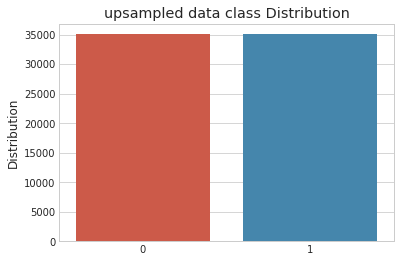

In [22]:
y = upsampled.Promoted_or_Not.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class Distribution')
plt.ylabel('Distribution')

### 2. Undersample majority class

Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a tonnes of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [23]:
Not_Promoted_downsampled = resample(Not_Promoted,
                                replace = False, # sample without replacement
                                n_samples = len(Promoted), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([Not_Promoted_downsampled, Promoted])

# checking counts
downsampled.Promoted_or_Not.value_counts()

1    3241
0    3241
Name: Promoted_or_Not, dtype: int64

Let us visualize this again.

Text(0,0.5,'count')

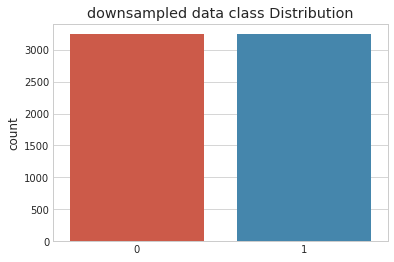

In [24]:
y = downsampled.Promoted_or_Not.value_counts()
sns.barplot(y = y,x = [0,1])
plt.title('downsampled data class Distribution')
plt.ylabel('count')

We will review other resampling techniques later in this notebook.

For ease of understanding, let's create a small unbalanced sample dataset using the make_classification method:

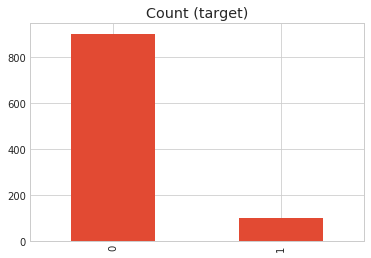

In [25]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1000, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')

We will do an experiment with this data without any resampling technique.
We will then fit and predict the data generated on a Logistic regression model and observe the output scores.

In [26]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)

In [27]:
probs,y_test=logistic(X,y)

We will define two functions to plot precision_recall curve and roc curve

In [28]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()

In [29]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

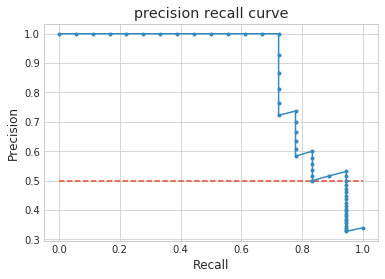

In [30]:
plot_pre_curve(y_test,probs)

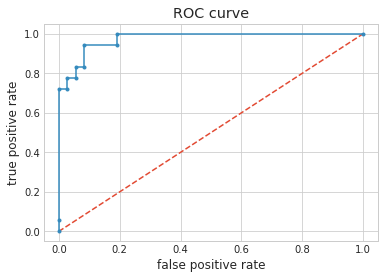

In [31]:
plot_roc(y_test,probs)

We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution:

In [32]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

### Dimensionality Reduction and Clustering  

Understanding t-SNE: In order to understand this algorithm you have to understand the following terms:

#### Euclidean Distance
#### Conditional Probability
#### Normal and T-Distribution Plots

In the section  below we will implement three major dimensionality reduction algorithms

##### *T-sne
##### *PCA
##### *Truncated SVD

In [33]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.9 s
PCA took 0.04 s
Truncated SVD took 0.0035 s


Now we will visualize the output of the above three algorithms in a 2D space.

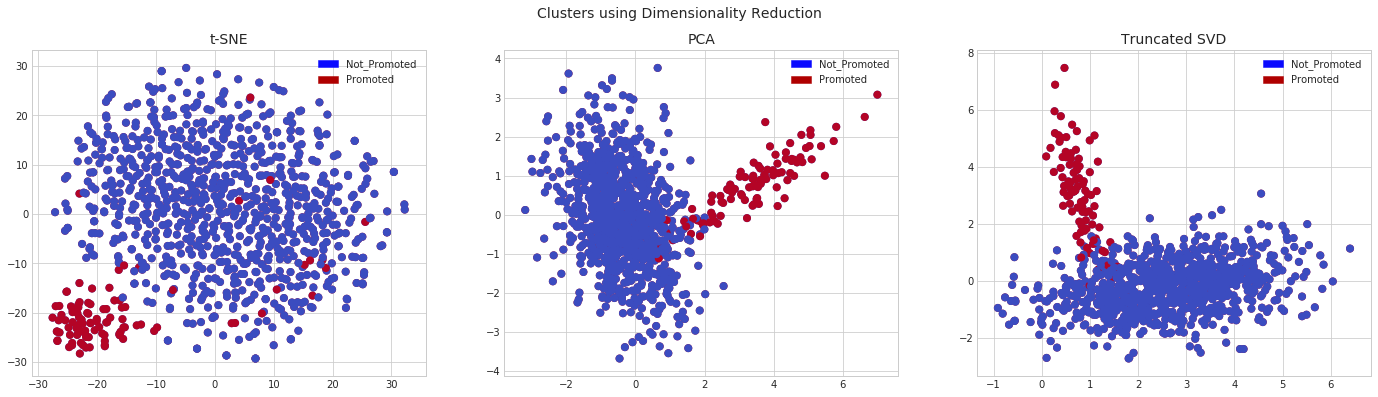

In [34]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Not_Promoted')
red_patch = mpatches.Patch(color='#AF0000', label='Promoted')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Not_Promoted', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Promoted', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Not_Promoted', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Promoted', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Not_Promoted', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Promoted', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### Python imbalanced-learn module

A number of more sophisticated resampling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [35]:
import imblearn

#### Random under-sampling with imbalanced-learn

The number of removed indices are  200


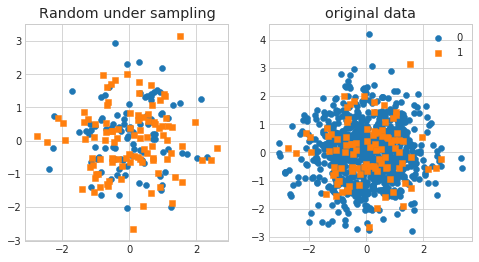

In [36]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler(return_indices=True) ##intialize to return indices of dropped rows
X_rs,y_rs,dropped = ran.fit_sample(X,y)

print("The number of removed indices are ",len(dropped))
plot_2d_space(X_rs,y_rs,X,y,'Random under sampling')

Let's try fit and predict on this data and observe the outcome.

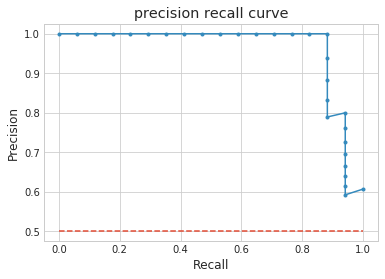

In [37]:
probs,y_test=logistic(X_rs,y_rs)
plot_pre_curve(y_test,probs)

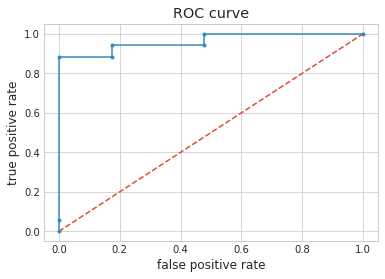

In [38]:
plot_roc(y_test,probs)

#### Random over-sampling with imbalanced-learn

The new data contains 1800 rows 


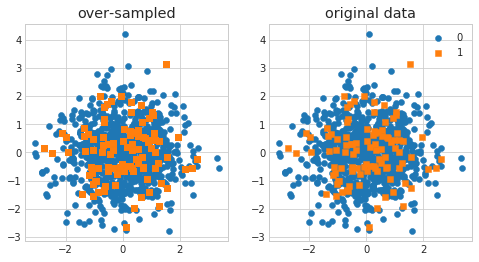

In [39]:
from imblearn.over_sampling import RandomOverSampler

ran=RandomOverSampler()
X_ran,y_ran= ran.fit_resample(X,y)

print('The new data contains {} rows '.format(X_ran.shape[0]))

plot_2d_space(X_ran,y_ran,X,y,'over-sampled')

Let's try fit and predict on this data and observe the outcome.

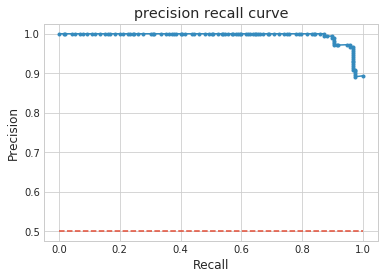

In [40]:
probs,y_test=logistic(X_ran,y_ran)
plot_pre_curve(y_test,probs)

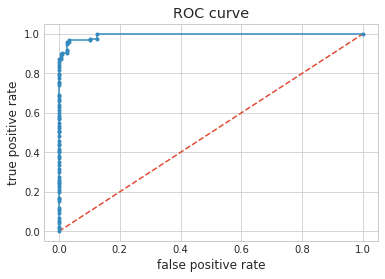

In [41]:
plot_roc(y_test,probs)

#### Under-sampling: Tomek Links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

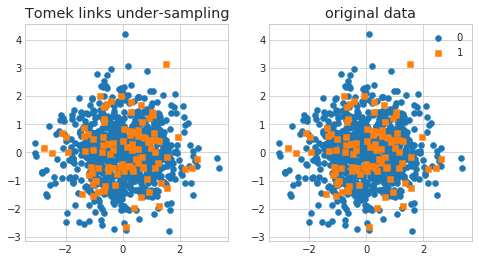

In [42]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl,X,y, 'Tomek links under-sampling')


Let's try fit and predict on this data and observe the outcome with this sampling method also.

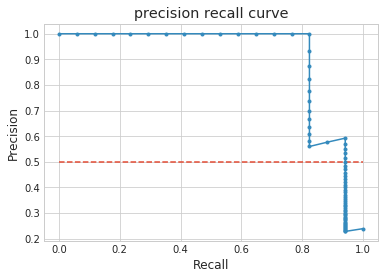

In [43]:
probs,y_test=logistic(X_tl,y_tl)
plot_pre_curve(y_test,probs)

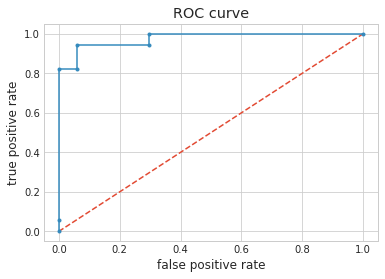

In [44]:
plot_roc(y_test,probs)

#### Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picing a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

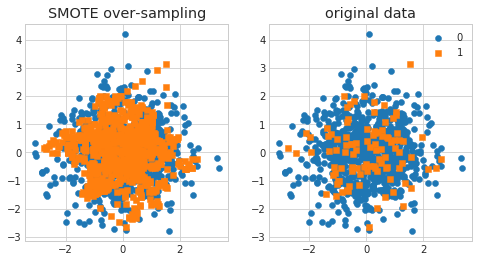

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

Let's try fit and predict on this data and observe the outcome.

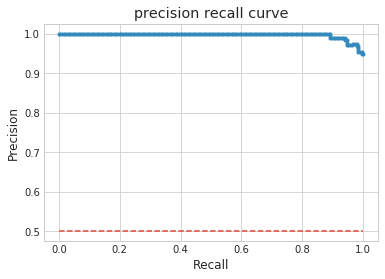

In [46]:
probs,y_test=logistic(X_sm,y_sm)
plot_pre_curve(y_test,probs)

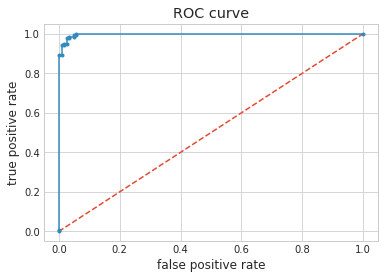

In [47]:
plot_roc(y_test,probs)

### Algorithmic Ensemble Techniques

The above section deals with handling imbalanced data by resampling original data to provide balanced classes. This method is an alternate approach i.e. Modifying existing classification algorithms to make them appropriate for imbalanced data sets.

The main objective of ensemble methodology is to improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their prediction. We shall implement this in our future commit.

#### XGBoost

XGBoost (Extreme Gradient Boosting) is an advanced and more efficient implementation of Gradient Boosting Algorithm discussed in the previous section.

Advantages over Other Boosting Techniques

It is 10 times faster than the normal Gradient Boosting as it implements parallel processing. It is highly flexible as users can define custom optimization objectives and evaluation criteria, has an inbuilt mechanism to handle missing values. Unlike gradient boosting which stops splitting a node as soon as it encounters a negative loss, XG Boost splits up to the maximum depth specified and prunes the tree backward and removes splits beyond which there is an only negative loss.

Extreme gradient boosting can be done using the XGBoost package in R and Python